<a href="https://colab.research.google.com/github/6862-2021SP-team3/pytorch-normalizing-flows/blob/master/nflib1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading the data and libraries
Clone the github repository, download the data file, and import needed libraries.


In [1]:
#Copy code into CoLab space
!git clone https://github.com/6862-2021SP-team3/pytorch-normalizing-flows.git

fatal: destination path 'pytorch-normalizing-flows' already exists and is not an empty directory.


In [2]:
#Copy training data from online repository
!wget -O pi0.pkl https://www.dropbox.com/s/hrdhr5o1khtclmy/pi0.pkl?dl=0

--2021-04-12 00:33:52--  https://www.dropbox.com/s/hrdhr5o1khtclmy/pi0.pkl?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hrdhr5o1khtclmy/pi0.pkl [following]
--2021-04-12 00:33:52--  https://www.dropbox.com/s/raw/hrdhr5o1khtclmy/pi0.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdb2b209231e9ed4968f63c5cd8.dl.dropboxusercontent.com/cd/0/inline/BMflSE6qUNRGpQKEbdbtrjhRVq6Lv7B2OiBWW19sdBnu_6sJPWsipvx6bj0QFdcxXY6wJS9sRYkFnUZi5KbstHGFU8nLYtbFxaUEzlFyjemBxpJQVwjvJaLw-5Q9bt96oJemdMTGwuYyNHWNVs_b3DTT/file# [following]
--2021-04-12 00:33:52--  https://ucdb2b209231e9ed4968f63c5cd8.dl.dropboxusercontent.com/cd/0/inline/BMflSE6qUNRGpQKEbdbtrjhRVq6Lv7B2OiBWW19sdBnu_6sJPWsipvx6bj0QFdcxXY6wJS9sRYkFnUZi5KbstHGFU8nLYtbFxaU

In [3]:
#Install module needed to unpack the downloaded data
!pip3 install pickle5
import pickle5 as pickle

In [4]:
#Add local modules to path
import sys
sys.path.insert(0,'/content/pytorch-normalizing-flows')


In [5]:
#Standard import statements
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from datetime import datetime

#Pytorch imports
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from torch.nn.parameter import Parameter

#NFlow library imports
from nflib.flows import (
    AffineConstantFlow, AffineHalfFlow, MLP, 
    NormalizingFlow, NormalizingFlowModel,
)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Define the data class
The data class reads the downloaded `pi0.pkl` and save them in the varaiable `xz`, `x`, `z`. The `x` and `z` contains encoded particle codes, which are not necessary for the flow model. The `xwithoutPid` and `zwithoutPid` are the varaiables don't contain particle codes for one row. The method `sample` is defined to pick partial rows in given size, where the row indices are randomized.

In [6]:
#Create data class
class dataXZ:
  """
  read the data stored in pickle format
  the converting routine is at https://github.com/6862-2021SP-team3/hipo2pickle
  """
  def __init__(self):
    with open('pi0.pkl', 'rb') as f:
        xz = np.array(pickle.load(f), dtype=np.float32)
        xz = xz[:, 1:]
        x = xz[:, :16]
        z = xz[:, 16:]
        xwithoutPid = x[:, [0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14]]
        zwithoutPid = z[:, [0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14]]
        self.xz = xz
        self.x = torch.from_numpy(np.array(x))
        self.z = torch.from_numpy(np.array(z))
        self.xwithoutPid = torch.from_numpy(xwithoutPid)
        self.zwithoutPid = torch.from_numpy(zwithoutPid)

  def sample(self, n):
        randint = np.random.randint( self.xz.shape[0], size =n)
        xz = self.xz[randint]
        x = self.x[randint]
        z = self.z[randint]
        xwithoutPid = self.xwithoutPid[randint]
        zwithoutPid = self.zwithoutPid[randint]
        return {"xz":xz, "x": x, "z": z, "xwithoutPid": xwithoutPid, "zwithoutPid": zwithoutPid}

In [7]:
xz = dataXZ()
z = xz.z
x = xz.x



findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


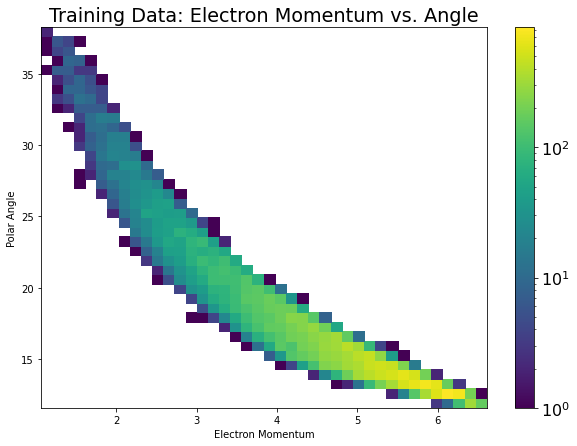

In [8]:
#Let's look at the data
sampleDict = xz.sample(30000) #Get a subset of the datapoints
x = sampleDict["xwithoutPid"][:, 0:2] #For now, only 
#print(x)
fig, ax = plt.subplots(figsize =(10, 7)) 
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "16"

ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")
#plt.scatter(x[:,0], x[:,1], c='g', s=5)
plt.title('Training Data: Electron Momentum vs. Angle')
x= x.detach().numpy()

plt.hist2d(x[:,0], x[:,1],bins =[40, 40],norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.colorbar()

In [9]:
sampleDict = xz.sample(100)
print(sampleDict["xz"][0])
print(sampleDict["xwithoutPid"][0])


[   3.7824557   18.13409   -161.02382      1.           0.7392999
   39.663536   -86.55176      2.           3.9946368   11.48676
   41.922726     3.           2.6111114   13.340397    48.98465
    3.           3.7800164   18.079142  -160.90982      1.
    0.9328663   39.607018   -76.034996     2.           3.8704987
   11.510034    41.601467     3.           2.5649562   13.354118
   49.142723     3.       ]
tensor([   3.7825,   18.1341, -161.0238,    0.7393,   39.6635,  -86.5518,
           3.9946,   11.4868,   41.9227,    2.6111,   13.3404,   48.9846])


## Construct a model
We try with a 2d example, electron momentum magnitude and polar angle only. The prior can be any constant distributions, or the parent distributions of `z`. At this stage, we look into the proof of concept, starting with 2d constant distribution. We firstly use the logistic distribution, which can be inverse transform sampled from sigmoid distribution. We pick Adam as our optimizer.

In [10]:
# construct a model
# try with electron momentum magintude and polar angle only
prior = TransformedDistribution(Uniform(torch.zeros(2), torch.ones(2)), SigmoidTransform().inv) # Logistic distribution
#prior = MultivariateNormal(torch.zeros(2), torch.eye(2)) # Normal distribution
# NICE
flows = [AffineHalfFlow(dim=2, parity=i%2, scale=False) for i in range(12)]
#print(flows)
flows.append(AffineConstantFlow(dim=2, shift=False))
#print(flows)


# construct the model
model = NormalizingFlowModel(prior, flows)

In [11]:
# optimizer
#optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-9) # this one was pretty good, but oscillates
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-9) # pretty solid, two bands
#optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-10) # weird tail at high electron momenutm
#optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-9) # 


print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  15278


In [12]:
model.train()
start_now = datetime.now()
start_time = start_now.strftime("%H:%M:%S")
print("Start Time =", start_time)
losses = []
for k in range(5000):
    sampleDict = xz.sample(1000)
    x = sampleDict["xwithoutPid"][:, 0:2] # try with electron momentum magintude and polar angle only.
    
    zs, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob) # NLL

    model.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    if k % 100 == 0:
        run_time = datetime.now()
        elapsedTime = (run_time - start_now )
        print("On step {} - loss {:.2f}, Current Running Time = {:.2f} seconds".format(k,loss.item(),elapsedTime.total_seconds())) 

now = datetime.now()
end_time = now.strftime("%H:%M:%S")
print("End Time =", end_time)
elapsedTime = (now - start_now )
print("Total Run Time = {:.5f} seconds".format(elapsedTime.total_seconds()))




Start Time = 00:34:12
On step 0 - loss 9210.32, Current Running Time = 0.12 seconds
On step 100 - loss 5656.97, Current Running Time = 1.47 seconds
On step 200 - loss 4297.65, Current Running Time = 2.78 seconds
On step 300 - loss 4165.03, Current Running Time = 4.20 seconds
On step 400 - loss 4083.26, Current Running Time = 5.53 seconds
On step 500 - loss 3987.98, Current Running Time = 6.84 seconds
On step 600 - loss 3923.41, Current Running Time = 8.14 seconds
On step 700 - loss 3844.57, Current Running Time = 9.44 seconds
On step 800 - loss 3759.76, Current Running Time = 10.83 seconds
On step 900 - loss 3701.83, Current Running Time = 12.26 seconds
On step 1000 - loss 3613.85, Current Running Time = 13.58 seconds
On step 1100 - loss 3548.53, Current Running Time = 14.89 seconds
On step 1200 - loss 3481.04, Current Running Time = 16.23 seconds
On step 1300 - loss 3433.11, Current Running Time = 17.62 seconds
On step 1400 - loss 3367.50, Current Running Time = 18.97 seconds
On step 

Text(0, 0.5, 'Loss')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


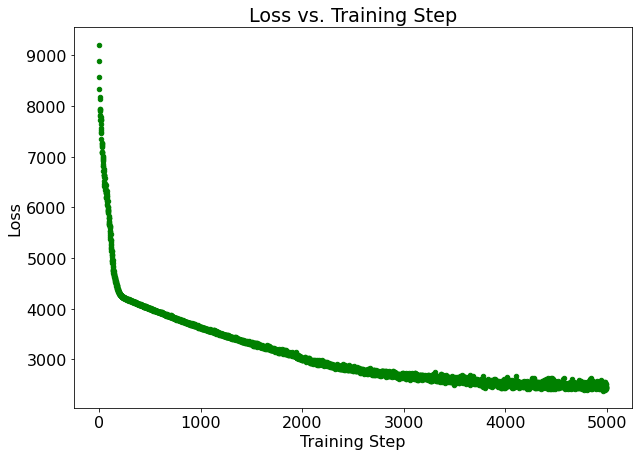

In [13]:
fig, ax = plt.subplots(figsize =(10, 7)) 
#print(np.arange(len(losses)))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "16"

plt.scatter(np.arange(len(losses)),losses, c='g', s=20)
plt.title('Loss vs. Training Step')
ax.set_xlabel("Training Step")  
ax.set_ylabel("Loss")

tensor([ 3.8933, 16.9089])


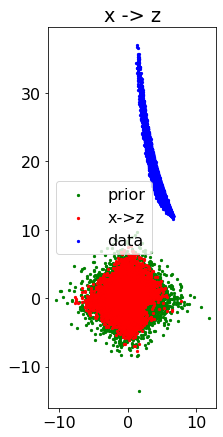

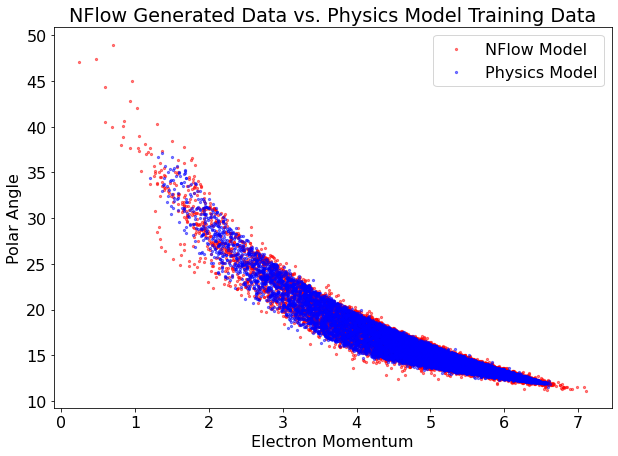

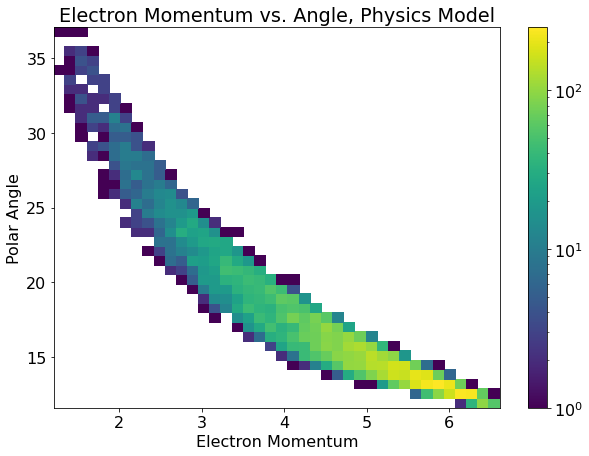

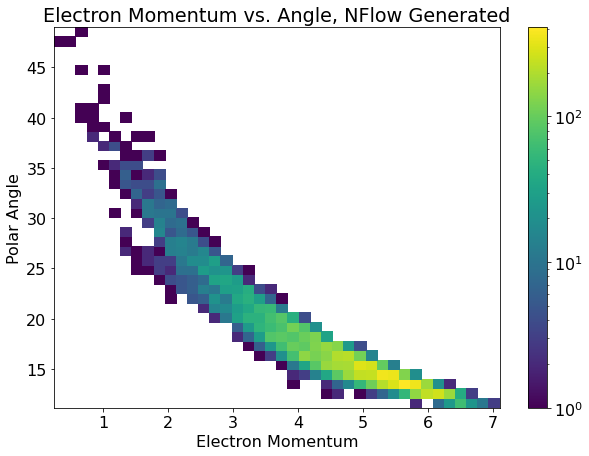

In [14]:
model.eval()
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "16"

sampleDict = xz.sample(10000)
x = sampleDict["xwithoutPid"][:, 0:2]
print(x[0])
zs, prior_logprob, log_det = model(x)
z = zs[-1]

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample([10000, 2]).squeeze()
fig, ax = plt.subplots(figsize =(10, 7)) 
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')


zs = model.sample(10000)
z = zs[-1]
z = z.detach().numpy()
fig, ax = plt.subplots(figsize =(10, 7)) 
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.legend(['NFlow Model','Physics Model'])
plt.title('NFlow Generated Data vs. Physics Model Training Data')
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")

fig, ax = plt.subplots(figsize =(10, 7)) 
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")
#plt.scatter(x[:,0], x[:,1], c='g', s=5)
plt.title('Electron Momentum vs. Angle, Physics Model')
plt.hist2d(x[:,0], x[:,1],bins =[40, 40],norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.colorbar()


fig, ax = plt.subplots(figsize =(10, 7)) 
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")
plt.title('Electron Momentum vs. Angle, NFlow Generated')
#plt.scatter(x[:,0], x[:,1], c='g', s=5)
plt.hist2d(z[:,0], z[:,1],bins =[40, 40],norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.colorbar()

##Test with normal distirbution.
The prior can be normal distributions. We can test the results with the same architecture.

In [15]:
# construct a model
# try with electron momentum magintude and polar angle only
prior = MultivariateNormal(torch.zeros(2), torch.eye(2)) # Normal distribution
# prior = TransformedDistribution(Uniform(torch.zeros(2), torch.ones(2)), SigmoidTransform().inv) # Logistic distribution
# NICE
flows = [AffineHalfFlow(dim=2, parity=i%2, scale=False) for i in range(12)]
#print(flows)
flows.append(AffineConstantFlow(dim=2, shift=False))
#print(flows)


# construct the model
model = NormalizingFlowModel(prior, flows)

In [16]:
# optimizer
#optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-9) # this one was pretty good, but oscillates
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-9) # pretty solid, two bands
#optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-10) # weird tail at high electron momenutm
#optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-9) # 


print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  15278


In [17]:
model.train()
start_now = datetime.now()
start_time = start_now.strftime("%H:%M:%S")
print("Start Time =", start_time)
losses = []
for k in range(5000):
    sampleDict = xz.sample(1000)
    x = sampleDict["xwithoutPid"][:, 0:2] # try with electron momentum magintude and polar angle only.
    
    zs, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob) # NLL

    model.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    if k % 100 == 0:
        run_time = datetime.now()
        elapsedTime = (run_time - start_now )
        print("On step {} - loss {:.2f}, Current Running Time = {:.2f} seconds".format(k,loss.item(),elapsedTime.total_seconds())) 

now = datetime.now()
end_time = now.strftime("%H:%M:%S")
print("End Time =", end_time)
elapsedTime = (now - start_now )
print("Total Run Time = {:.5f} seconds".format(elapsedTime.total_seconds()))

Start Time = 00:35:22
On step 0 - loss 90998.55, Current Running Time = 0.03 seconds
On step 100 - loss 19528.55, Current Running Time = 1.54 seconds
On step 200 - loss 2945.34, Current Running Time = 2.99 seconds
On step 300 - loss 2925.68, Current Running Time = 4.32 seconds
On step 400 - loss 2816.58, Current Running Time = 5.62 seconds
On step 500 - loss 2810.04, Current Running Time = 6.92 seconds
On step 600 - loss 2851.36, Current Running Time = 8.26 seconds
On step 700 - loss 2736.24, Current Running Time = 9.56 seconds
On step 800 - loss 2858.19, Current Running Time = 10.87 seconds
On step 900 - loss 2808.52, Current Running Time = 12.17 seconds
On step 1000 - loss 2802.86, Current Running Time = 13.55 seconds
On step 1100 - loss 2822.10, Current Running Time = 14.87 seconds
On step 1200 - loss 2815.85, Current Running Time = 16.16 seconds
On step 1300 - loss 2784.03, Current Running Time = 17.44 seconds
On step 1400 - loss 2768.80, Current Running Time = 18.74 seconds
On ste

Text(0, 0.5, 'Loss')

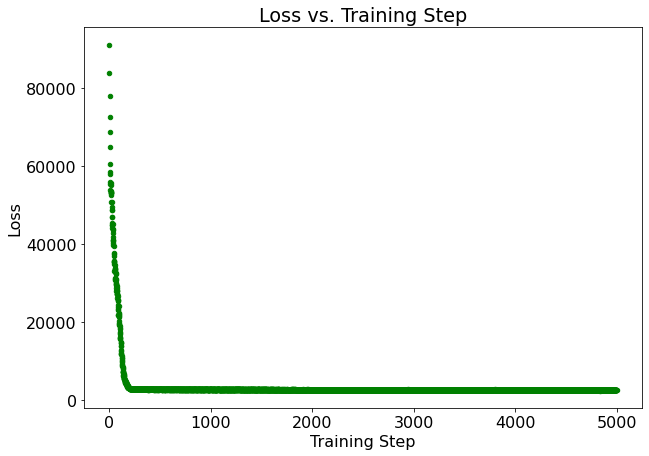

In [18]:
fig, ax = plt.subplots(figsize =(10, 7)) 
#print(np.arange(len(losses)))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "16"

plt.scatter(np.arange(len(losses)),losses, c='g', s=20)
plt.title('Loss vs. Training Step')
ax.set_xlabel("Training Step")  
ax.set_ylabel("Loss")

tensor([ 5.9447, 12.7239])


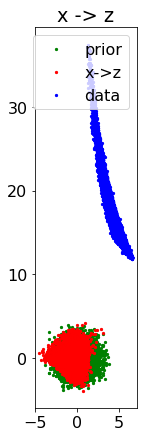

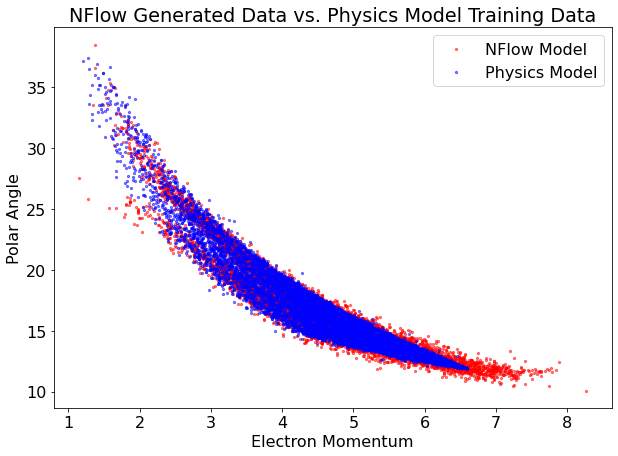

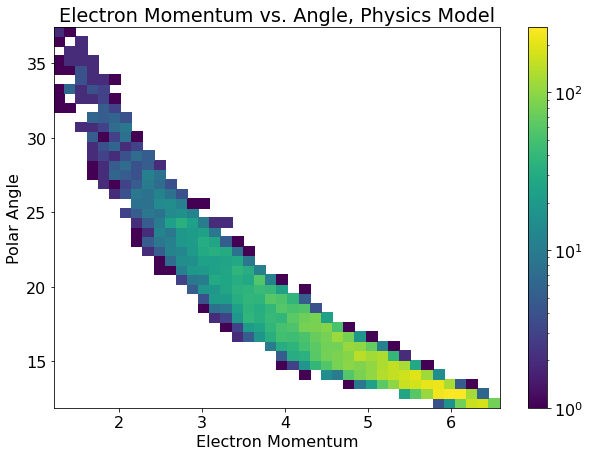

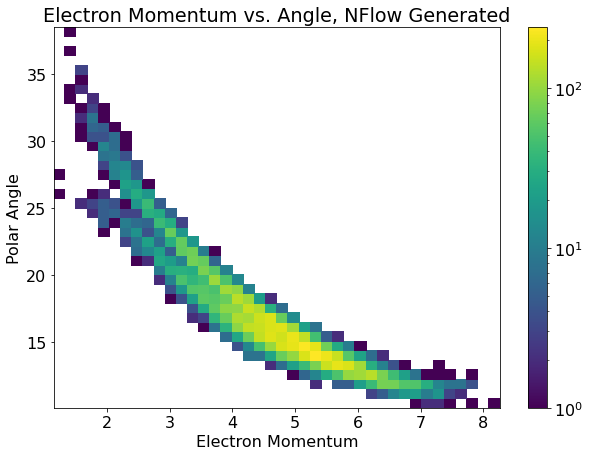

In [19]:
model.eval()
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "16"

sampleDict = xz.sample(10000)
x = sampleDict["xwithoutPid"][:, 0:2]
print(x[0])
zs, prior_logprob, log_det = model(x)
z = zs[-1]

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample([10000, 2]).squeeze()
fig, ax = plt.subplots(figsize =(10, 7)) 
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')


zs = model.sample(10000)
z = zs[-1]
z = z.detach().numpy()
fig, ax = plt.subplots(figsize =(10, 7)) 
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.legend(['NFlow Model','Physics Model'])
plt.title('NFlow Generated Data vs. Physics Model Training Data')
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")

fig, ax = plt.subplots(figsize =(10, 7)) 
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")
#plt.scatter(x[:,0], x[:,1], c='g', s=5)
plt.title('Electron Momentum vs. Angle, Physics Model')
plt.hist2d(x[:,0], x[:,1],bins =[40, 40],norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.colorbar()


fig, ax = plt.subplots(figsize =(10, 7)) 
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")
plt.title('Electron Momentum vs. Angle, NFlow Generated')
#plt.scatter(x[:,0], x[:,1], c='g', s=5)
plt.hist2d(z[:,0], z[:,1],bins =[40, 40],norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.colorbar()